## Title: Model Selection and Validation
- Author: Maha Siraj
- November 2, 2017


#### Modelling objective 
Modelling Consumer Response to Marketing. classify which customers will respond to direct mail marketing based on data collected for past customers.



### Content within this Notebook:
- Standardise Predictors
- Define Threshold based on the cost-benefit table (**business success criteria**)
- Modeling
 - Logistic regression, with ridge, lasso
 - Support vector machines
 - XGBoost
 - Gaussian discriminant analysis (LDA and QDA)
- Evaluation
 - benchmark
 - calculate F1, recall and recision
 - ROC plot
 - Precision recall curve
 - **Bootstrap** for comfidence interval
 - Significant Coefficient Histogram for L1

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns
import warnings
import statsmodels.formula.api as smf
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import norm, skew
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
import sklearn.metrics as skl_metrics
import sklearn.linear_model as skl_lm
from sklearn.lda import LDA 
from sklearn.qda import QDA
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge 
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor 
import nltk
from statlearning import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score, precision_score,  roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV ## used in logistic model
from asm2 import forward_logistic
from QBUS2820 import forward
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from asm2 import forward_logisticl1   # use liblinear
from asm2 import forward_logisticl2    
from asm2 import pcrCV_logistic
from asm2 import PCR_logistic
from asm2 import PCR_CV_logistic
from asm2 import PCR_CV_logistic_l1
from asm2 import pcrCV_logistic_l1
from asm2 import PCR_CV_logistic_l2
from asm2 import pcrCV_logistic_l2

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn.calibration import CalibratedClassifierCV
from xgboost import DMatrix
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import average_precision_score
from sklearn.svm.libsvm import decision_function
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score, make_scorer
from YiranJing import hist

blue = sns.color_palette('Blues')[-2]
color = sns.color_palette() 
sns.set_style('darkgrid') 
#pd.set_option('display.float_foimport nltk 

/Users/yiran/anaconda/lib/python3.6/site-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
/Users/yiran/anaconda/lib/python3.6/site-packages/sklearn/qda.py:6: DeprecationWarning: qda.QDA has been moved to discriminant_analysis.QuadraticDiscriminantAnalysis in 0.17 and will be removed in 0.19.
  "in 0.17 and will be removed in 0.19.", DeprecationWarning)
/Users/yiran/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:

data=pd.read_csv("finalDataset_transformall_task1.csv")  

state=460244129  # use yiran's id
train = data.sample(frac=0.8, random_state=state)
test = data[data.index.isin(train.index)==False].copy() 

# separate predictor and response
response = ['RESP']
EXCLUDE1=response +['HHKEY','ZIP_CODE','VALPHON','CC_CARD','WEB']  # exculde 3 dummy for QDA METHOD
#EXCLUDE1=response +['HHKEY','ZIP_CODE','VALPHON','CC_CARD','WEB','MAILED','PROMOS','STORES','COUPONS','CLUSTYPE'
                    #,'STORELOY','DAYS','PC_CALC20']
#EXCLUDE1=response +['HHKEY','ZIP_CODE','VALPHON','CC_CARD']
variables1=[x for x in list(train.columns) if x not in EXCLUDE1]

EXCLUDE2=response +['HHKEY','ZIP_CODE']
variables2=[x for x in list(train.columns) if x not in EXCLUDE2]


X_train_nodummy = train[variables1]
X_test_nodummy = test[variables1]
X_train = train[variables2]
X_test = test[variables2]

y_train = train['RESP']
y_test=test["RESP"]

###  standardise Predictors

In [3]:
## standardise
## you can find any transformation information in "dataset for task 1 jupyter notebook"
mu=X_train.mean()
sigma=X_train.std()

X_train=(X_train-mu)/sigma
X_test=(X_test-mu)/sigma 

mu1=X_train_nodummy.mean()
sigma1=X_train_nodummy.std()

X_train_nodummy=(X_train_nodummy-mu1)/sigma1
X_test_nodummy=(X_test_nodummy-mu1)/sigma1



### Define Threshold based on the business rule

In [4]:
# define coefficients we used in this business case.
n_test=len(test)
n_testP=len(test[test["RESP"]==1])  # the number of y==1 in testset
n_testN=len(test[test["RESP"]==0]) # the number of y==0 in testset
loss_TN=0    # No lost profit
loss_TP=-19.3343  # Estimated profit minus cost of mailing 
loss_FN=21.3343 # Loss profit
loss_FP=2 # cost of marketing , material postage and handling cost

threshold=(loss_FP--loss_TN)/(loss_FP+loss_FN-loss_TP-loss_TN)
threshold

def classification(y_prob,threshold):
    y_pred = np.zeros(len(test))
    x= range(0,len(test))
    for i in x:
        if y_prob[i,1]>threshold:
            y_pred[i]=1
        else:
            y_pred[i]=0
        
    return y_pred

### principle component logistic

In [5]:
%%time
## simple logistic 
pcr_cv = pcrCV_logistic(X_train, y_train) 
pcr_cv.fit(X_train, y_train)

CPU times: user 59.6 s, sys: 8.17 s, total: 1min 7s
Wall time: 38.6 s


## Model 1: logistic regression

### simple logit

In [6]:
logit = LogisticRegression()
logit.fit(X_train, y_train) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [7]:
logit_weight = LogisticRegression(class_weight={0: 0.5, 1: 0.5})
logit_weight.fit(X_train, y_train) 

LogisticRegression(C=1.0, class_weight={0: 0.5, 1: 0.5}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [8]:
method=logit_weight
#y_pred = method.predict(X_test)
y_prob = method.predict_proba(X_test)
y_pred = classification(y_prob,threshold)
confusion  = confusion_matrix(y_test, y_pred)
n1=(confusion[0,0]*loss_TN+confusion[0,1]*loss_FP+confusion[1,0]*loss_FN+confusion[1,1]*loss_TP)/n_test
n2=f1_score(y_test, y_pred)
n3=average_precision_score(y_test, y_pred)
print(n1)
print(n2)  
print(n3)

-2.34882946182
0.429346274622
0.628429038142


### logistic ridge shrikage

In [9]:
# logistic ridge shrikage
# cv= 10 to select hyperparameter by default
logit_l2 = skl_lm.LogisticRegressionCV(penalty='l2')
logit_l2.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

### logistic with lasso

In [10]:
# L-1 Regularised logistic regression (lasso shrinkage)
logit_l1 = LogisticRegressionCV(penalty='l1', solver='liblinear')
logit_l1.fit(X_train, y_train) 

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           refit=True, scoring=None, solver='liblinear', tol=0.0001,
           verbose=0)

### forward logic

In [11]:
%%time
# simple logistic
fwd1 = forward_logistic()
fwd1.fit(X_train, y_train) 

CPU times: user 2min 23s, sys: 18.1 s, total: 2min 41s
Wall time: 1min 28s


In [12]:
%%time
## fwd with ridge shinkage
fwd4 = forward_logisticl2()
fwd4.fit(X_train, y_train)

CPU times: user 9min 57s, sys: 1min 1s, total: 10min 59s
Wall time: 5min 56s


## Model 2: support vector machines

http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [13]:
# have shrinkage as well 
svm_linear = SVC(kernel='linear',probability=True,class_weight='balanced')
svm_linear.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC
http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html#sklearn.calibration.CalibratedClassifierCV

In [14]:
## Linear Support Vector Classification with lasso shrikge
lsvc_l1 = LinearSVC(penalty='l1',dual=False, class_weight='balanced')
clf1 = CalibratedClassifierCV(lsvc_l1)
lsvc_l1.fit(X_train, y_train)
clf1.fit(X_train, y_train)

y_proba1 = clf1.predict_proba(X_test)

### after balance weight, we use cross validation to select the best class weight

In [15]:
## Linear Support Vector Classification with lasso shrikge
lsvc_l1_weight = LinearSVC(penalty='l1',dual=False, class_weight={0: 0.15, 1: 0.85})  ## CV select weight
clf3 = CalibratedClassifierCV(lsvc_l1_weight)
lsvc_l1_weight.fit(X_train, y_train)
clf3.fit(X_train, y_train)
y_proba3 = clf3.predict_proba(X_test)

In [16]:
## Linear Support Vector Classification with ridge shrinkage
lsvc_l2 = LinearSVC(penalty='l2', class_weight='balanced')
clf2 = CalibratedClassifierCV(lsvc_l2)
lsvc_l2.fit(X_train, y_train)
clf2.fit(X_train, y_train)
y_proba2 = clf2.predict_proba(X_test)

## Model 3: XGBoost classifier

https://stackoverflow.com/questions/34674797/xgboost-xgbclassifier-defaults-in-python
http://xgboost.readthedocs.io/en/latest/python/python_api.html



In [17]:
xgboost = XGBClassifier()
xgboost.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

## Model 3: Gaussian discriminant analysis
LDA AND QDA

### exclude the binary predictor for this class of models.

only three dummy, but as "WEB"(online shopping) is a useful dummy variable for prediction(you can check plot in EDA jupyter notebook), so i really want to try naive bayes including one dummy.
we trade customer type as numerical data currently, but multinulli could be better i guess, but it is still a bias- variance trade off and our decision should be based on the final test performance result.

In [18]:
## LDA AND QDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_nodummy, y_train)

qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_nodummy, y_train)  

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariances=False, tol=0.0001)

In [19]:
# long term run 

## regularisation
from sklearn.model_selection import cross_val_score

def qda_cv(X_train, y_train): 
    
    alphas  = np.linspace(0, 1, 21)  # hyperparameter
    best_score = -np.inf
    
    for alpha in alphas:
        qda = QuadraticDiscriminantAnalysis(reg_param=alpha)
        score = np.mean(cross_val_score(qda, X_train, y_train, cv=10, scoring = 'f1'))
        if score >= best_score:
            best = qda
            best_score = score
    
    return qda.fit(X_train, y_train)
        
qda_reg = qda_cv(X_train_nodummy, y_train) 

# Step 5 : Evaluation

You can use the following techniques to verify the classifier performance.
Accuracy
Confusion matrix
Receiver operating characteristics (ROC)
Area under ROC curve (AUC)
for the discussion of this part, we should focus on "two substantively different models" , i.e. generative and discriminative classifiers
if the assumption of gaussian discriminant analysis is apprapariate here (i.e. the boxcox transformation is efficient), the lda/qda should be more efficiency. so, we can based on the test performation of all models to rediscussion our dataset and eda result.

http://scikit-learn.org/stable/modules/model_evaluation.html

## test error

In [20]:
# define coefficients we used in this business case.
n_test=len(test)
n_testP=len(test[test["RESP"]==1])  # the number of y==1 in testset
n_testN=len(test[test["RESP"]==0]) # the number of y==0 in testset
loss_TN=0    # No lost profit
loss_TP=-19.3343  # Estimated profit minus cost of mailing 
loss_FN=21.3343 # Loss profit
loss_FP=2 # cost of marketing , material postage and handling cost

threshold=(loss_FP--loss_TN)/(loss_FP+loss_FN-loss_TP-loss_TN)
threshold

def classification(y_prob,threshold):
    y_pred = np.zeros(len(test))
    x= range(0,len(test))
    for i in x:
        if y_prob[i,1]>threshold:
            y_pred[i]=1
        else:
            y_pred[i]=0
        
    return y_pred

import inspect
print(inspect.getsource(logit.predict))



### benchmark

In [21]:
# Don’t send to anyone
TN=n_testN
FN=n_test-n_testN
average_cost_donotsend=(loss_TN*TN+FN*loss_FN)/n_test
# send to everyone
TP=FN
FP=TN
average_cost_sendtoEvery=(loss_TP*TP+FP*loss_FP)/n_test
print('If Don’t send to anyone, the cost is:   $', average_cost_donotsend)
print('If send to averageone, the cost is:   $', average_cost_sendtoEvery)

If Don’t send to anyone, the cost is:   $ 3.7732467111315544
If send to averageone, the cost is:   $ -1.7732467111315546


Therefore, it is this “send to everyone” model that we shall define as our baseline model, and the profit of $1.77 per customer is defined as the benchmark profit that any candidate model should outperform.

### F-score
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score


The F1 score can be interpreted as a weighted average of the precision and recall, l, where an F1 score reaches its best value at 1 and worst score at 0.

### Precision-Recall
http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score
to evaluate classifier output quality.

The average precision score is the area under the precision recall curve
Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.

The precision-recall curve shows the tradeoff between precision and recall for different threshold, A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

The latter, predict_proba is a method of a (soft) classifier outputting the probability of the instance being in each of the classes.
The former, decision_function, finds the distance to the separating hyperplane. For example, a(n) SVM classifier finds hyperplanes separating the space into areas associated with classification outcomes. This function, given a point, finds the distance to the separators.

In [22]:
### The worest test error based on no model 
# use test data for test error (classification risk)
## this one use np.zeros(len(test)) as our prediction, means we predict all are 0 (as most are negative)

error  = 1 - accuracy_score(np.zeros(len(test)), test['RESP']) # if zero, correct prediction.
print(error.round(4))
threshold=(loss_FP--loss_TN)/(loss_FP+loss_FN-loss_TP-loss_TN)
threshold

0.1769


0.04687287607280295

In [23]:
print('If send to averageone, the cost is:   $', average_cost_sendtoEvery)  
#print('So, our best models should have lower average cost. while we prefer lowest average cost, we still need consider F1 value and average Percision, as our decison threshold is subjective and could be biasd')

## table of models 
columns=['Error rate(0-1 loss)', 'Sensitivity', 'Specificity', 'AUC', 'Precision','Average cost($)','actual cost/profit($)','F score','average precision']
rows=['L1 Linear Support Vector','CV （0：15%, 1:85%）L1 Linear Support Vector','L2 Linear Support Vector','linear support vector machines','XGBoost','PCR Logistic','Logistic', 'L1 logistic', 'L2 logistic', 'Forward logistic','Forward L2 logistic','LDA', 'QDA', 'Regularised QDA']
results=pd.DataFrame(0.0, columns=columns, index=rows) 


methods=[lsvc_l1, lsvc_l1_weight, lsvc_l2, svm_linear, xgboost, pcr_cv, logit, logit_l1, logit_l2, fwd1, fwd4, lda, qda, qda_reg]

for i, method in enumerate(methods):
    
    if i == 0:
        #y_pred = method.predict(X_test)
        y_prob = y_proba1
        y_pred = classification(y_prob,threshold)
    if i == 1:
        #y_pred = method.predict(X_test)
        y_prob = y_proba3
        y_pred = classification(y_prob,threshold)
    if i == 2:
        #y_pred = method.predict(X_test)
        y_prob = y_proba2
        y_pred = classification(y_prob,threshold)
    if i > 2 and i < 11:  
        #y_pred = method.predict(X_test)
        y_prob = method.predict_proba(X_test)
        y_pred = classification(y_prob,threshold)
    if i > 10:
        #y_pred = method.predict(X_test_nodummy)
        y_prob = method.predict_proba(X_test_nodummy)
        y_pred = classification(y_prob,threshold)
       
    confusion  = confusion_matrix(y_test, y_pred) 
    error_rate =  1 - accuracy_score(y_test, y_pred) 
    #y_score = method.decision_function(X_test)
    p=(confusion[0,0]+confusion[1,0])/n_test  # the probablity that i forecast to y=0.
    #se = np.std(x, ddof=1)/np.sqrt(len(x)) #sampling std   # ddof 是df , in one sample t test , it can be removed.
    #ci_low = xmean - se*stats.t.ppf(0.995, df=len(x)-1)
    #ci_high = xmean + se*stats.t.ppf(0.995, df=len(x)-1)
    

    results.iloc[i,0]=  error_rate
    results.iloc[i,1]=  confusion[1,1]/np.sum(confusion[1,:]) #sensitivity 
    results.iloc[i,2]=  confusion[0,0]/np.sum(confusion[0,:])  #specificity 
    results.iloc[i,3]=  roc_auc_score(y_test, y_prob[:,1])  # auc
    results.iloc[i,4]=  precision_score(y_test, y_pred)   # precision
    results.iloc[i,5]=  (confusion[0,0]*loss_TN+confusion[0,1]*loss_FP+confusion[1,0]*loss_FN+confusion[1,1]*loss_TP)/n_test
    results.iloc[i,6]=  (confusion[0,0]*loss_TN+confusion[0,1]*loss_FP+confusion[1,0]*0+confusion[1,1]*loss_TP)/n_test
    results.iloc[i,7] = f1_score(y_test, y_pred)
    results.iloc[i,8] = average_precision_score(y_test, y_pred)
results.round(4)

If send to averageone, the cost is:   $ -1.7732467111315546


,Error rate(0-1 loss),Sensitivity,Specificity,AUC,Precision,Average cost($),actual cost/profit($),F score,average precision
L1 Linear Support Vector,0.4591,0.9805,0.4465,0.8592,0.2757,-2.3680,-2.4416,0.4304,0.6298
"CV （0：15%, 1:85%）L1 Linear Support Vector",0.4575,0.9805,0.4484,0.8592,0.2764,-2.3712,-2.4448,0.4312,0.6302
L2 Linear Support Vector,0.4584,0.9779,0.4479,0.8589,0.2757,-2.3516,-2.4350,0.4301,0.6287
linear support vector machines,0.4600,0.9792,0.4457,0.8589,0.2751,-2.3573,-2.4358,0.4295,0.6290
XGBoost,0.4708,0.9753,0.4334,0.8582,0.2700,-2.3090,-2.4022,0.4229,0.6248
PCR Logistic,0.4568,0.9766,0.4501,0.8591,0.2762,-2.3459,-2.4342,0.4306,0.6285
Logistic,0.4568,0.9766,0.4501,0.8591,0.2762,-2.3459,-2.4342,0.4306,0.6285
L1 logistic,0.4828,0.9857,0.4166,0.8588,0.2663,-2.3562,-2.4102,0.4194,0.6273
L2 logistic,0.4811,0.9805,0.4197,0.8577,0.2663,-2.3238,-2.3974,0.4189,0.6251
Forward logistic,0.4607,0.9766,0.4454,0.8596,0.2745,-2.3381,-2.4264,0.4285,0.6276


#### overbalance

consider misclassification costs
In some contexts, certain kinds of errors are more costly than others. Misclassification costs are basically weights applied to specific outcomes. These weights are factored into the model and may actually change the prediction (as a way of protecting against costly mistakes).

The cost matrix shows the cost for each possible combination of predicted category and actual category. By default, all misclassification costs are set to 1.0.(0-1 loss) To enter custom cost values, select Use misclassification costs and enter your custom values into the cost matrix.

To change a misclassification cost, select the cell corresponding to the desired combination of predicted and actual values, delete the existing contents of the cell, and enter the desired cost for the cell. Costs are not automatically symmetrical. For example, if you set the cost of misclassifying A as B to be 2.0, the cost of misclassifying B as A will still have the default value of 1.0 unless you explicitly change it as well.

However, clearly this is a moot point since none of these models come close to the minimum benchmark of $1.623 profit per customer established by the “send to everyone” model.

Why are these models performing so poorly? The answer is that we have not applied misclassification costs. To develop candidate models that we will evaluate using a strictly defined cost–benefit matrix, we should seek to embed these costs within the models themselves

## ROC

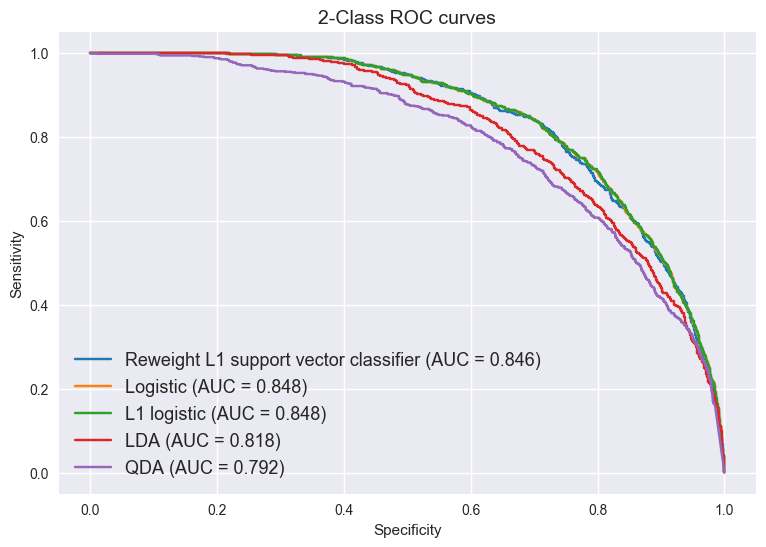

In [263]:
palette = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD']

from sklearn.metrics import roc_curve

labels=['Reweight L1 support vector classifier', 'Logistic', 'L1 logistic', 'LDA','QDA']
methods=[lsvc_l1_weight, logit, logit_l1, lda, qda]

fig, ax= plt.subplots(figsize=(9,6))

for i, method in enumerate(methods):
    if i == 0:
        y_prob = y_proba1
    if i > 0 and i < 3:
        y_prob = method.predict_proba(X_test)
    if i >= 3:
        y_prob = method.predict_proba(X_test_nodummy)
        
    fpr, tpr, _ = roc_curve(y_test, y_prob[:,1])
    auc = roc_auc_score(y_test, y_prob[:,1])
    ax.plot(1-fpr, tpr, label=labels[i] + ' (AUC = {:.3f})'.format(auc), color = palette[i])
    
ax.set_xlabel('Specificity')
ax.set_ylabel('Sensitivity')
ax.set_title('2-Class ROC curves', fontsize=14)
plt.legend(fontsize=13)
plt.show()

## precision recall curve
The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

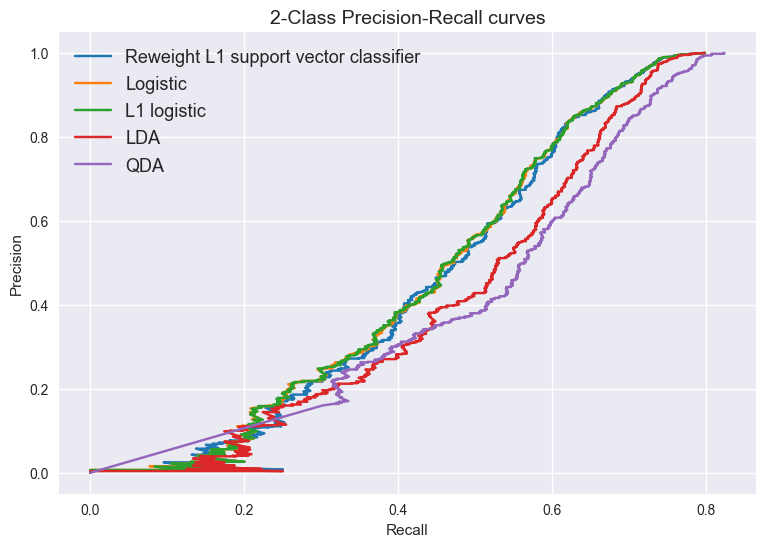

In [256]:
from sklearn.metrics import precision_recall_curve

palette = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD']

from sklearn.metrics import roc_curve

labels=['Reweight L1 support vector classifier', 'Logistic', 'L1 logistic', 'LDA', 'QDA']
methods=[lsvc_l1_weight, logit, logit_l1, lda, qda]

fig, ax= plt.subplots(figsize=(9,6))

for i, method in enumerate(methods):
    if i == 0:
        y_prob = y_proba1
    if i>0 and i < 3:
        y_prob = method.predict_proba(X_test)
    if i >=3 :
        y_prob = method.predict_proba(X_test_nodummy)
        
    fpr, tpr, _ = precision_recall_curve(y_test, y_prob[:,1])
    socre = roc_auc_score(y_test, y_prob[:,1])
    ax.plot(1-fpr, tpr, label=labels[i], color = palette[i])
    
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('2-Class Precision-Recall curves', fontsize=14)
plt.legend(fontsize=13)
plt.show()


## Bootstrap for comfidence interval

In [25]:
%%time

# Settings
S = 10000 
n1 = len(test)

boot1=[] 
boot2=[]
boot3=[] 
boot4=[] 
boot5=[]
for i in range(S):
    xs= test.iloc[np.random.randint(n1, size=n1)]  # generate n samples with replacement , in test set
    X_test_resample_nodummy = xs[variables1]
    X_test_resample = xs[variables2]
    y_test_resample = xs["RESP"]
   
    X_test_resample=(X_test_resample-mu)/sigma
    X_test_resample_nodummy=(X_test_resample_nodummy-mu1)/sigma1
    
    methods=[logit, logit_l1, lsvc_l1, lsvc_l1_weight, lda]  ## selected method 
    
    
    ## Logistic
    y_prob = logit.predict_proba(X_test_resample)
    y_pred = classification(y_prob,threshold)
    confusion1  = confusion_matrix(y_test_resample, y_pred)
    boot1.append((confusion1[0,0]*loss_TN+confusion1[0,1]*loss_FP+confusion1[1,0]*loss_FN+confusion1[1,1]*loss_TP)/n_test)
    
    ## logit_l1
    y_prob = logit_l1.predict_proba(X_test_resample)
    y_pred = classification(y_prob,threshold)
    confusion4  = confusion_matrix(y_test_resample, y_pred)
    boot4.append((confusion4[0,0]*loss_TN+confusion4[0,1]*loss_FP+confusion4[1,0]*loss_FN+confusion4[1,1]*loss_TP)/n_test)
    
    ## L1 SVM
    y_prob = clf1.predict_proba(X_test_resample)
    y_pred = classification(y_prob,threshold)
    confusion5  = confusion_matrix(y_test_resample, y_pred)
    boot5.append((confusion5[0,0]*loss_TN+confusion5[0,1]*loss_FP+confusion5[1,0]*loss_FN+confusion5[1,1]*loss_TP)/n_test)
    
    ## reweight SVC L1
    y_prob = clf3.predict_proba(X_test_resample)
    y_pred = classification(y_prob,threshold)
    confusion2  = confusion_matrix(y_test_resample, y_pred)
    boot2.append((confusion2[0,0]*loss_TN+confusion2[0,1]*loss_FP+confusion2[1,0]*loss_FN+confusion2[1,1]*loss_TP)/n_test)
    
    ## LDA 
    y_prob = lda.predict_proba(X_test_resample_nodummy)
    y_pred = classification(y_prob,threshold)
    confusion3  = confusion_matrix(y_test_resample, y_pred)
    boot3.append((confusion3[0,0]*loss_TN+confusion3[0,1]*loss_FP+confusion3[1,0]*loss_FN+confusion3[1,1]*loss_TP)/n_test)

CPU times: user 25min 34s, sys: 3min 8s, total: 28min 42s
Wall time: 16min


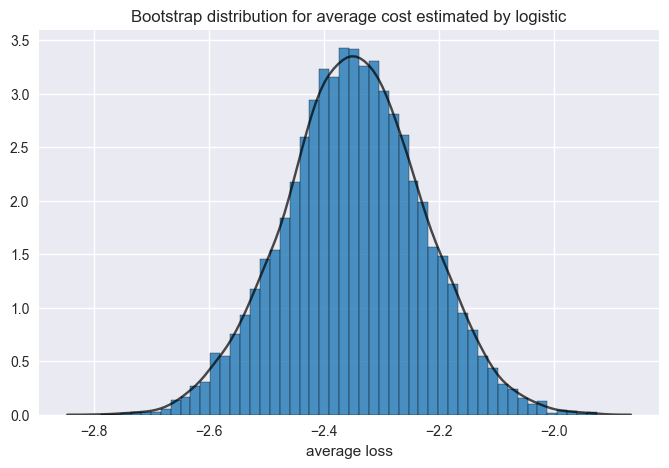

In [26]:
fig, ax = hist(boot1)
ax.set_title('Bootstrap distribution for average cost estimated by logistic')
ax.set_xlabel('average loss')
plt.show()

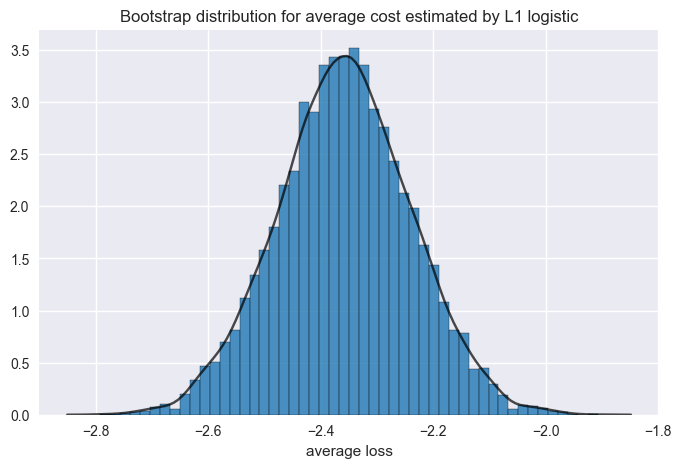

In [27]:
fig, ax = hist(boot4)
ax.set_title('Bootstrap distribution for average cost estimated by L1 logistic')
ax.set_xlabel('average loss')
plt.show()

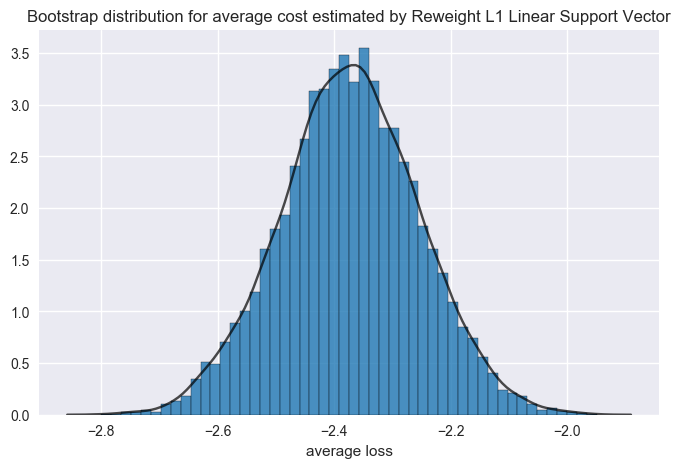

In [28]:
fig, ax = hist(boot2)
ax.set_title('Bootstrap distribution for average cost estimated by Reweight L1 Linear Support Vector')
ax.set_xlabel('average loss')
plt.show()

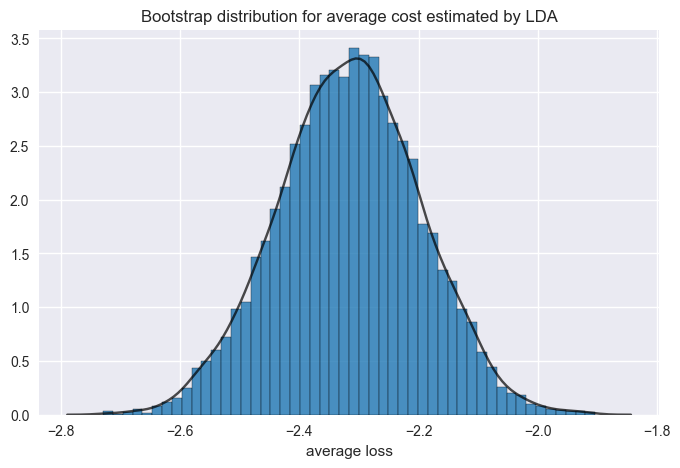

In [29]:
fig, ax = hist(boot3)
ax.set_title('Bootstrap distribution for average cost estimated by LDA')
ax.set_xlabel('average loss')
plt.show()

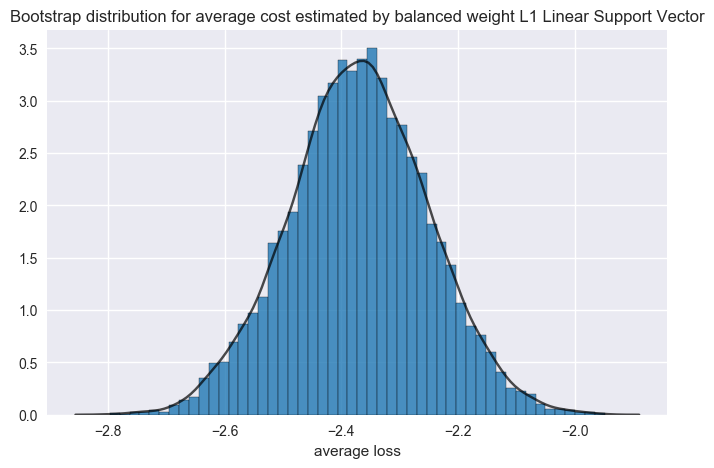

In [30]:
fig, ax = hist(boot5)
ax.set_title('Bootstrap distribution for average cost estimated by balanced weight L1 Linear Support Vector')
ax.set_xlabel('average loss')
plt.show()

In [31]:
# bootstrap percentile interval 
ci_low = np.percentile(boot1, 0.5)
ci_high = np.percentile(boot1, 99.5)
print("logistic CI: ")
print(round(ci_low, 3))
print(round(ci_high, 3))
print("-----------------------------")
ci_low = np.percentile(boot4, 0.5)
ci_high = np.percentile(boot4, 99.5)
print("L1 logistic CI: ")
print(round(ci_low, 3))
print(round(ci_high, 3))
print("-----------------------------")
ci_low = np.percentile(boot2, 0.5)
ci_high = np.percentile(boot2, 99.5)
print("L1 SVM (CV weight) CI: ")
print(round(ci_low, 3))
print(round(ci_high, 3))
print("-----------------------------")
ci_low = np.percentile(boot5, 0.5)
ci_high = np.percentile(boot5, 99.5)
print("L1 SVM (balanced weight) CI: ")
print(round(ci_low, 3))
print(round(ci_high, 3))
print("-----------------------------")
ci_low = np.percentile(boot3, 0.5)
ci_high = np.percentile(boot3, 99.5)
print("LDA CI: ")
print(round(ci_low, 3))
print(round(ci_high, 3))

logistic CI: 
-2.65
-2.037
-----------------------------
L1 logistic CI: 
-2.662
-2.04
-----------------------------
L1 SVM (CV weight) CI: 
-2.673
-2.068
-----------------------------
L1 SVM (balanced weight) CI: 
-2.671
-2.065
-----------------------------
LDA CI: 
-2.617
-2.009


In [32]:

print('lda beta0 = ', lda.intercept_)
print('lda beta1 = ', lda.coef_)

lda beta0 =  [-2.38177605]
lda beta1 =  [[ 0.81092942 -0.05496497 -0.02475014 -0.01799977 -0.04496639 -0.52561414
   0.14814849  0.02096526  0.00329812 -0.02431343 -0.09474039  0.09056692
  -0.27452022 -0.01605871 -0.02585956 -0.02818552  0.00992509  0.01688826
   0.00653674 -0.01187695 -0.04781833  0.14232803  0.08699377  0.04098072
  -0.00429898  0.01981874 -0.04586902 -0.03480515  0.02603059  0.0364707
   0.02425231  0.03255845 -1.61498447  1.5307825  -0.02235961  0.04042115
   0.06211769  0.04123758  0.02141659 -0.00754215  1.16575176  0.1352158
  -0.74391404 -0.1187715  -0.14770535]]


In [33]:

print('lsvc_l1_weight beta0 = ', lsvc_l1_weight.intercept_)
print('lsvc_l1_weight beta1 = ', lsvc_l1_weight.coef_)

lsvc_l1_weight beta0 =  [-0.29591367]
lsvc_l1_weight beta1 =  [[  4.94532240e-03  -1.70457934e-02  -1.59367554e-02  -3.03596170e-03
   -6.66151034e-03  -3.77624131e-03  -1.54662145e-01   2.65662319e-02
   -7.91717900e-03  -2.30458530e-02  -2.29294907e-03   1.73001368e-02
    1.70454587e-02  -4.47853771e-02  -2.04293471e-03  -8.97723538e-02
   -2.96187451e-03  -1.28987251e-02  -8.76478353e-03   1.24467005e-02
   -9.80282187e-04   2.65417268e-02   1.51208335e-03  -1.30866791e-02
    6.23927733e-03  -1.11172369e-03  -3.21615760e-04   9.97095648e-03
    8.83934686e-03  -1.44528284e-02  -8.47099367e-03   1.15506960e-02
    1.71779027e-02  -3.36605098e-03   3.35702597e-02  -8.67172144e-01
    7.51510370e-01  -1.33116526e-02  -1.14918400e-02   2.93194296e-02
    2.06739040e-02  -1.53223906e-03   7.10995018e-03   6.97487610e-01
   -1.67614678e-02  -4.52123041e-01  -4.53183887e-02  -4.58334040e-02]]


In [34]:

print('logit_l1 beta0 = ', logit_l1.intercept_)
print('logit_l1 beta1 = ', logit_l1.coef_)

logit_l1 beta0 =  [-2.39667467]
logit_l1 beta1 =  [[  1.96280752e-01  -3.32231102e-02   0.00000000e+00   0.00000000e+00
    0.00000000e+00  -4.73110098e-04   0.00000000e+00   0.00000000e+00
   -3.03776862e-02  -2.81656453e-02   0.00000000e+00   2.04039038e-02
    5.45235003e-02  -7.33364725e-02  -3.17914249e-02  -1.63495672e-01
    0.00000000e+00   0.00000000e+00  -1.11111536e-02   0.00000000e+00
    0.00000000e+00   3.90354201e-02   0.00000000e+00  -4.40545417e-03
    1.93126175e-02   0.00000000e+00   4.94142054e-03   0.00000000e+00
    8.86926816e-03  -2.22258094e-02  -2.65118942e-03   5.69206230e-03
    2.41297479e-02   0.00000000e+00   0.00000000e+00  -1.89742006e+00
    1.08910676e+00  -1.94286303e-02  -3.06959693e-02   6.22817593e-02
    5.54618971e-02   0.00000000e+00   0.00000000e+00   7.39232408e-01
   -3.23620020e-02  -5.27535879e-01  -1.04556557e-02   0.00000000e+00]]


In [36]:
## Linear Support Vector Classification with lasso shrikge
svc=pd.DataFrame(lsvc_l1.coef_.T,index=variables2)
svc.columns = ['coefficient']

In [37]:
significant = svc[np.abs(svc.coefficient) > 0.01]

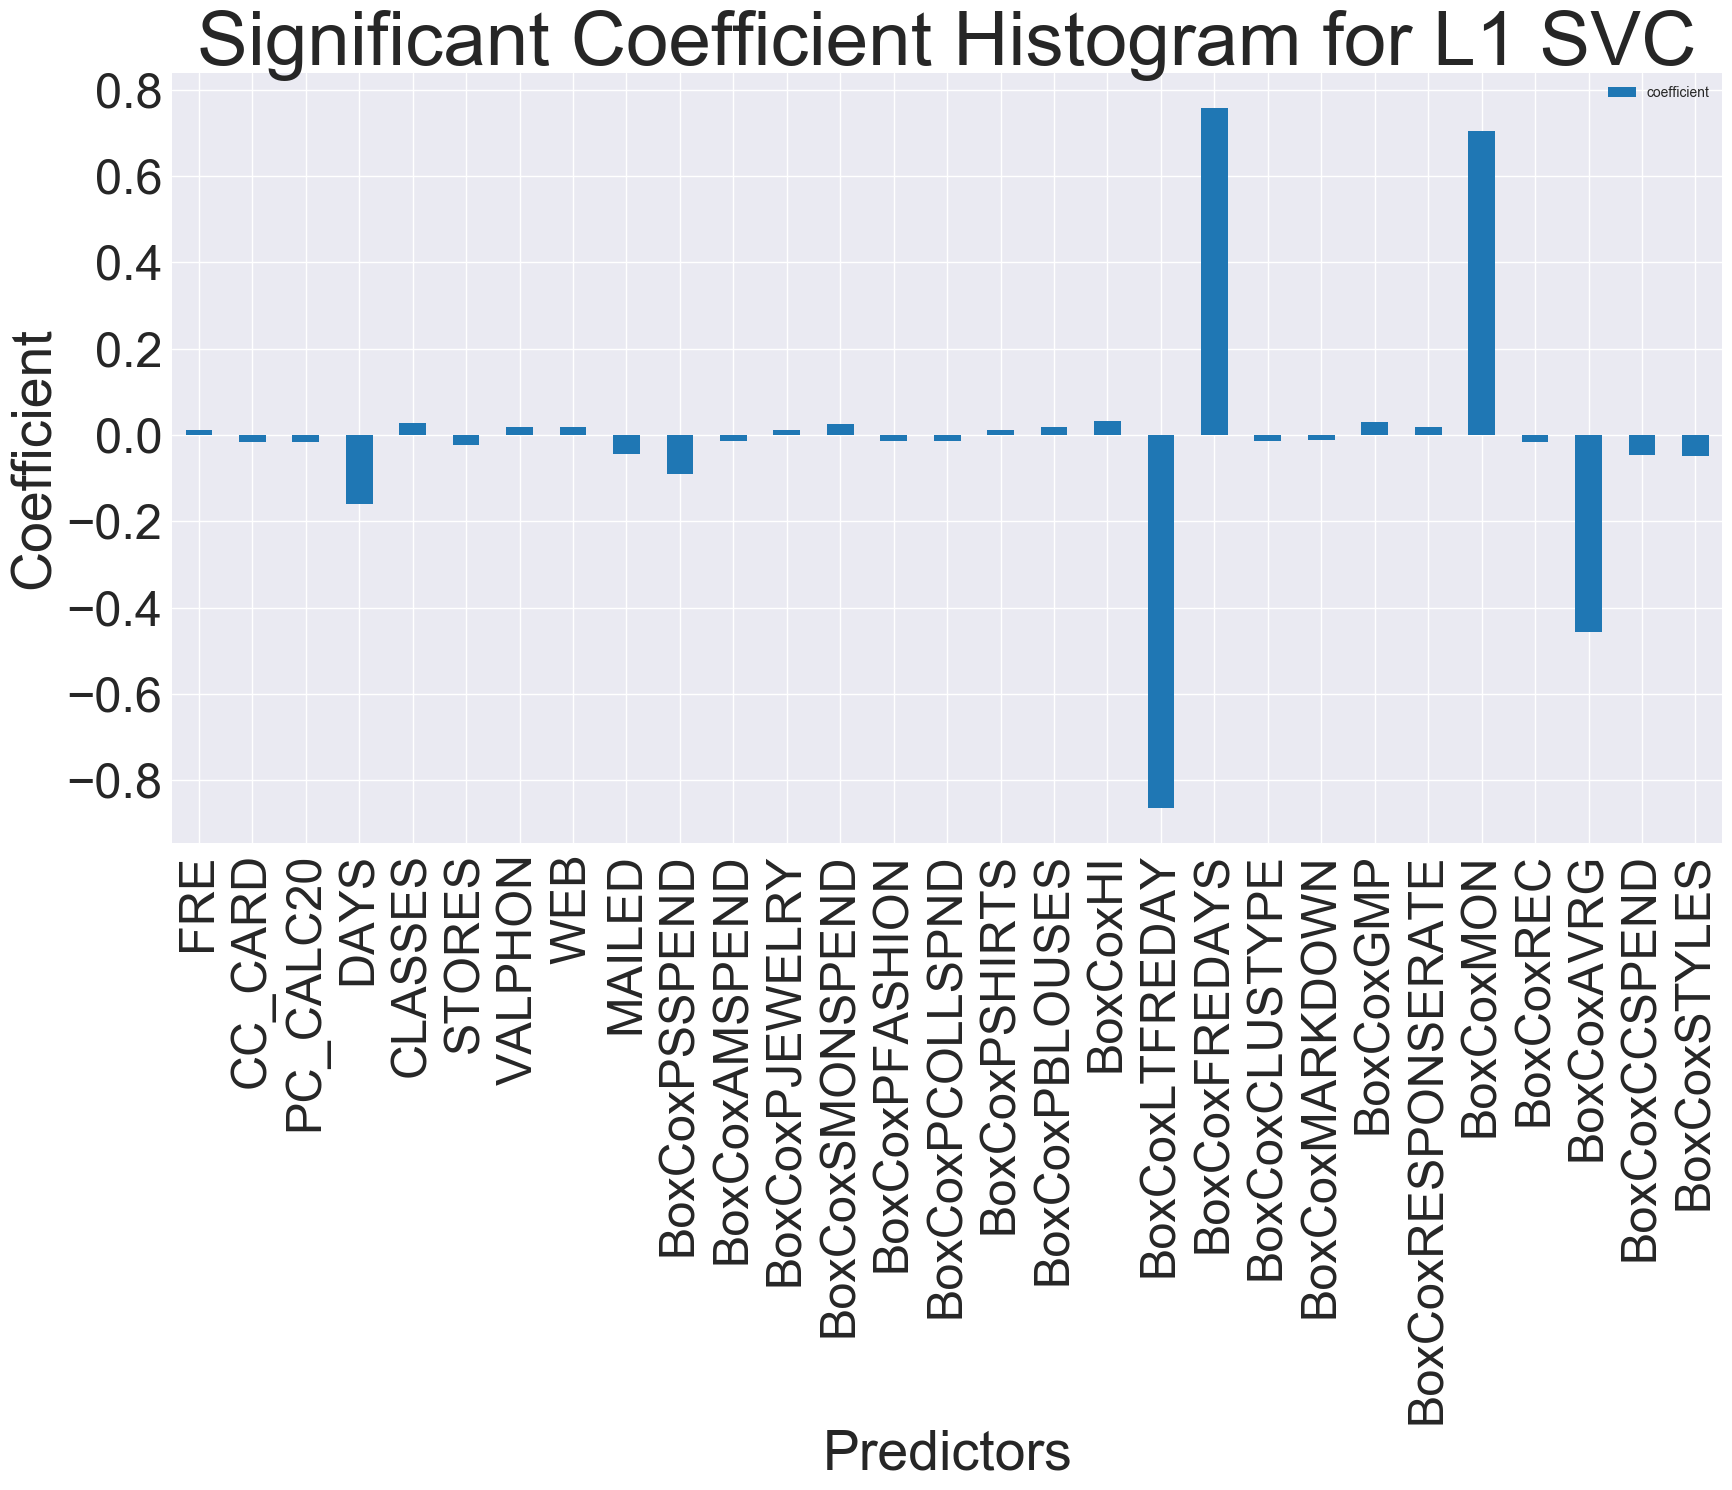

In [38]:
fig, ax= plt.subplots()
significant.plot(ax=ax,kind='bar',figsize=(20,10),fontsize=35)
ax.set_title('Significant Coefficient Histogram for L1 SVC',fontsize=55)
ax.set_ylabel('Coefficient',fontsize=40)
ax.set_xlabel('Predictors',fontsize=40)
plt.show()

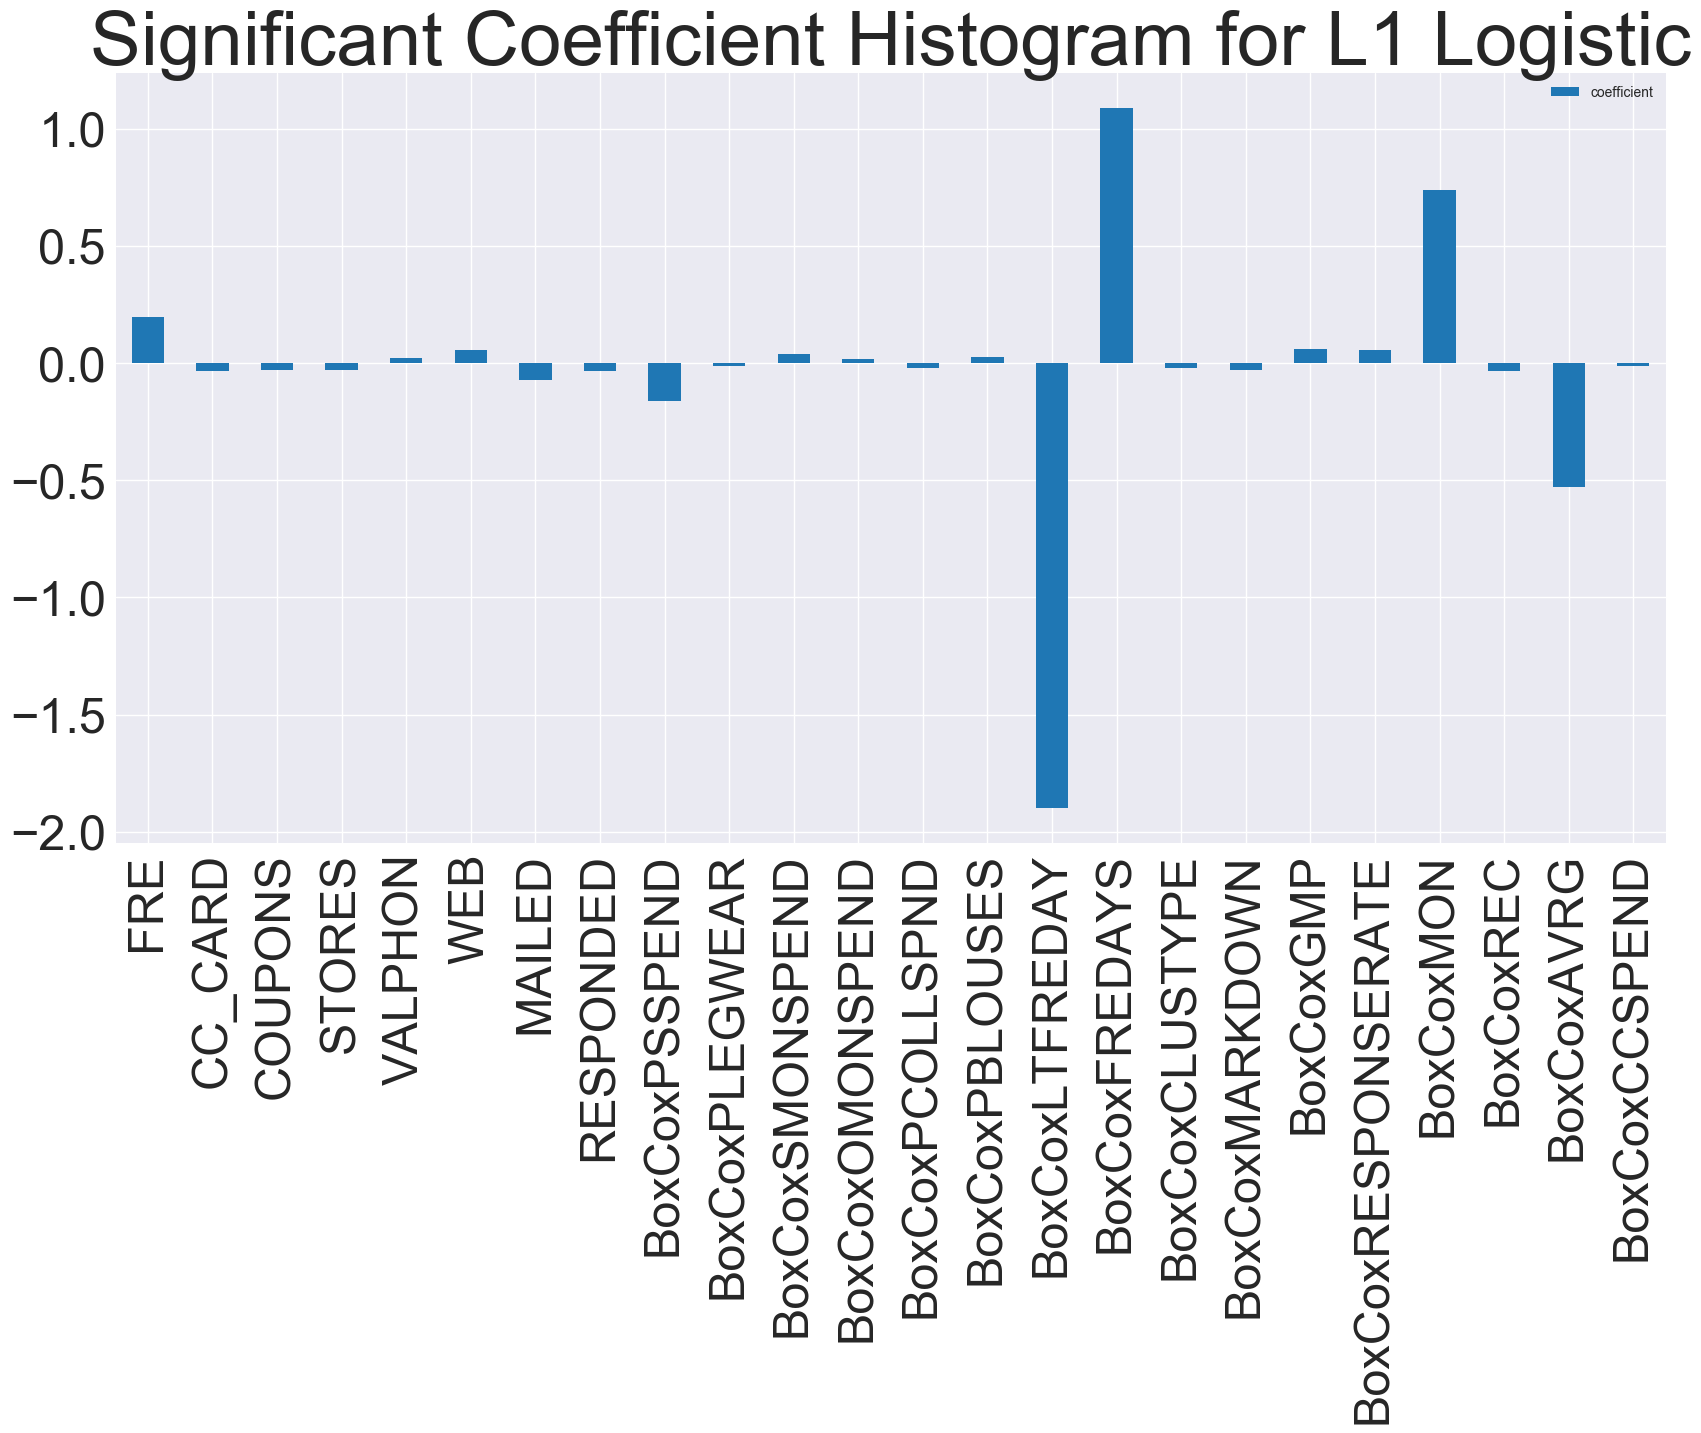

In [40]:
# L-1 Regularised logistic regression (lasso shrinkage)
logit_l1 = LogisticRegressionCV(penalty='l1', solver='liblinear')
logit_l1.fit(X_train, y_train)
logit_l1.coef_.T
lo=pd.DataFrame(logit_l1.coef_.T,index=variables2)
lo.columns = ['coefficient']
significant = lo[np.abs(lo.coefficient) > 0.01]
fig, ax= plt.subplots()
significant.plot(ax=ax,kind='bar',figsize=(20,10),fontsize=35)
ax.set_title('Significant Coefficient Histogram for L1 Logistic',fontsize=55)
plt.show()